In [1]:
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import cv2
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,f1_score,mean_absolute_error,classification_report
from keras import Model
from tensorflow.keras.layers import Input,Activation,Add, MaxPooling2D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow import keras
from tensorflow.keras import layers, models
from skimage import color
from skimage import filters
import tensorflow as tf
from tensorflow.keras.regularizers import L1L2
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D, LeakyReLU

### Get filter function that outputs the sobel filter from an image

### Choose the label type

In [2]:
# Choose the label type
Labeltype = 'age'
replacev = False
Nlabels = -1
if(Labeltype == 'age'):
    Nlabels = 9
if(Labeltype == 'gender'):
    Nlabels = 2
if(Labeltype == 'race'):
    Nlabels = 5

### Get the file paths and labels
### Split into train-test-validate
### Balance the train paths and labels

In [3]:
# Import image labels and paths to dataframe
mypath = "../data/raw/CroppedImages/"
filenames = np.array([f for f in listdir(mypath) if isfile(join(mypath, f))])
splitcolumns = [x.split('_')[0:3] + [mypath + x] for x in filenames if x.count('_') == 3]
filecolumns = ['age','gender','race','file']
filedf = pd.DataFrame(data = splitcolumns, columns = filecolumns).astype({'age': 'int', 'gender': 'int', 'race': 'int'})

# Convert age to appropriate labels
filedf['age']=np.where((filedf.age<3), 0, filedf.age)
filedf['age']=np.where(((filedf.age>=3) & (filedf.age<6)), 1, filedf.age)
filedf['age']=np.where(((filedf.age>=6) & (filedf.age<9)), 2, filedf.age)
filedf['age']=np.where(((filedf.age>=9) & (filedf.age<12)), 3, filedf.age)
filedf['age']=np.where(((filedf.age>=12) & (filedf.age<21)), 4, filedf.age)
filedf['age']=np.where(((filedf.age>=21) & (filedf.age<36)), 5, filedf.age)
filedf['age']=np.where(((filedf.age>=36) & (filedf.age<51)), 6, filedf.age)
filedf['age']=np.where(((filedf.age>=51) & (filedf.age<80)), 7, filedf.age)
filedf['age']=np.where((filedf.age>=80), 8, filedf.age)

dfx = filedf.loc[:,'file']
dfy = filedf.loc[:,Labeltype]

# Get Train/Test
X_train, X_test, y_train, y_test = train_test_split(dfx, dfy, test_size=0.2, random_state=42)

# Get Train/Test/Validation dataset 0.25 * 8 = 0.2
X_train_2, X_val, y_train_2, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Encode training labels and initialize random over sampler
yencoded = LabelEncoder().fit_transform(y_train_2)
oversample = RandomOverSampler()

# Over sample until training classes are balanced
X_train_balanced, y_train_balanced = oversample.fit_resample(np.array(X_train_2).reshape(-1,1), yencoded)

# Of all classes, proportionally sample 10000
dxy = {'file': X_train_balanced.reshape(len(X_train_balanced)), 'label': y_train_balanced}
dfbalanced = pd.DataFrame(data = dxy)
balancedsamples = int(10000/len(set(dfbalanced.loc[:,'label'])))
dfbalancedsubset = dfbalanced.groupby('label', group_keys=False).apply(lambda x: x.sample(balancedsamples, replace = replacev)).sample(frac=1)

# Count and print prebalanced classes
counter = Counter(y_train)
for k,v in counter.items():
    per = v / len(y_train) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

# Count and print balanced classes
counter = Counter(y_train_balanced)
for k,v in counter.items():
    per = v / len(y_train_balanced) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

# Count and print balanced classes subsets (Total should be 10000)
counter = Counter(dfbalancedsubset.loc[:,'label'])
for k,v in counter.items():
    per = v / len(dfbalancedsubset.loc[:,'label']) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=7, n=3134 (16.526%)
Class=5, n=8166 (43.061%)
Class=3, n=323 (1.703%)
Class=8, n=541 (2.853%)
Class=0, n=1277 (6.734%)
Class=2, n=426 (2.246%)
Class=4, n=1290 (6.802%)
Class=6, n=3199 (16.869%)
Class=1, n=608 (3.206%)
Class=5, n=6093 (11.111%)
Class=2, n=6093 (11.111%)
Class=6, n=6093 (11.111%)
Class=0, n=6093 (11.111%)
Class=8, n=6093 (11.111%)
Class=7, n=6093 (11.111%)
Class=3, n=6093 (11.111%)
Class=4, n=6093 (11.111%)
Class=1, n=6093 (11.111%)
Class=7, n=1111 (11.111%)
Class=3, n=1111 (11.111%)
Class=5, n=1111 (11.111%)
Class=2, n=1111 (11.111%)
Class=8, n=1111 (11.111%)
Class=0, n=1111 (11.111%)
Class=6, n=1111 (11.111%)
Class=4, n=1111 (11.111%)
Class=1, n=1111 (11.111%)


### Get color images + mask

In [4]:
# Convert images to sobel edges
#train_img_container = robertsSobelEdgesImproved(dfbalancedsubset.loc[:,'file'].values)
#validation_img_container = robertsSobelEdgesImproved(X_val)
#test_img_container = robertsSobelEdgesImproved(X_test)
# Get train images
train_img_container = np.zeros((len(dfbalancedsubset.loc[:,'file']),200,200,4))
for index,i in enumerate(dfbalancedsubset.loc[:,'file']):
    img = cv2.imread(i)
    grayImg = color.rgb2gray(img)
    edge_sobel = filters.sobel(grayImg)
    train_img_container[index,:,:,:3]=img/255
    train_img_container[index,:,:,3]=edge_sobel
#train_img_container = np.array(train_img_container)

# Get validation images
validation_img_container = np.zeros((len(X_val),200,200,4))
for index,i in enumerate(X_val):
    img = cv2.imread(i)
    grayImg = color.rgb2gray(img)
    edge_sobel = filters.sobel(grayImg)
    validation_img_container[index,:,:,:3]=img/255
    validation_img_container[index,:,:,3]=edge_sobel
#validation_img_container = np.array(validation_img_container)

# Get testing images
test_img_container = np.zeros((len(X_test),200,200,4))
for index,i in enumerate(X_test):
    img = cv2.imread(i)
    grayImg = color.rgb2gray(img)
    edge_sobel = filters.sobel(grayImg)
    test_img_container[index,:,:,:3]=img/255
    test_img_container[index,:,:,3]=edge_sobel
#test_img_container = np.array(test_img_container)

### Function to get images

In [4]:
def get_images(filelist,rgb = True, sobel = True):
    dims = 0
    if(rgb):
        dims+=3
    else:
        dims+=1
    if(sobel):
        dims+=1
    container = np.zeros((len(filelist),200,200,dims))
    if(rgb): 
        for index,i in enumerate(filelist):
            img = cv2.imread(i)
            container[index,:,:,:3]=img
            if(sobel):
                grayImg = color.rgb2gray(img)
                edge_sobel = filters.sobel(grayImg)
                container[index,:,:,3]=edge_sobel
    else:
        for index,i in enumerate(filelist):
            img = cv2.imread(i)
            grayImg = color.rgb2gray(img)
            container[index,:,:,0]=grayImg
            if(sobel):
                edge_sobel = filters.sobel(grayImg)
                container[index,:,:,1]=edge_sobel
    return container

In [7]:
del train_img_container
del validation_img_container
del test_img_container

In [8]:
del CNNmodel

In [9]:
train_img_container = get_images(dfbalancedsubset.loc[:,'file'],rgb = False, sobel = True)
validation_img_container = get_images(X_val,rgb = False, sobel = True)
test_img_container = get_images(X_test,rgb = False, sobel = True)

In [18]:
train_img_container.shape

(9999, 200, 200, 1)

### Get Greyscale Sobel images

### Arrays for tracking the history of attempts

In [ ]:
l1history = []
l2history = []
dropouthistory = []
valhistory = []
testhistory = []
conhistory = []

In [11]:
l1reg = 0
l2reg = 0
dropoutn = 0.4
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience = 3,
    verbose=1,
    mode="auto",
    restore_best_weights=True,
)
CNNmodel = models.Sequential()
CNNmodel.add(layers.Conv2D(32, (3, 3), activation=LeakyReLU(), input_shape=train_img_container[0].shape, 
                           kernel_regularizer = L1L2(l1=l1reg, l2=l2reg)))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
CNNmodel.add(layers.Conv2D(64, (3, 3), activation=LeakyReLU(),kernel_regularizer = L1L2(l1=l1reg, l2=l2reg)))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
CNNmodel.add(layers.Conv2D(128, (3, 3), activation=LeakyReLU(),kernel_regularizer = L1L2(l1=l1reg, l2=l2reg)))
CNNmodel.add(layers.Flatten())
CNNmodel.add(layers.Dense(64, activation=LeakyReLU()))
CNNmodel.add(Dropout(dropoutn))

CNNmodel.add(layers.Dense(Nlabels, activation='softmax'))
CNNmodel.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])                
# Validation training and testing
val_history = CNNmodel.fit(train_img_container, np.array(dfbalancedsubset.loc[:,'label'])
                           , epochs=10
                           , validation_data=(validation_img_container, y_val)
                           ,callbacks=[callback]
                           )

Epoch 1/10
313/313 [==============================] - 272s 867ms/step - loss: 1.6618 - accuracy: 0.4196 - val_loss: 1.4556 - val_accuracy: 0.4138
Epoch 2/10
313/313 [==============================] - 265s 846ms/step - loss: 0.8929 - accuracy: 0.6732 - val_loss: 1.2637 - val_accuracy: 0.5349
Epoch 3/10
313/313 [==============================] - 265s 847ms/step - loss: 0.5690 - accuracy: 0.7904 - val_loss: 1.2377 - val_accuracy: 0.5478
Epoch 4/10
313/313 [==============================] - 265s 848ms/step - loss: 0.3892 - accuracy: 0.8617 - val_loss: 1.3458 - val_accuracy: 0.5554
Epoch 5/10
313/313 [==============================] - 260s 831ms/step - loss: 0.3076 - accuracy: 0.8972 - val_loss: 1.6208 - val_accuracy: 0.5360
Epoch 6/10
313/313 [==============================] - 255s 815ms/step - loss: 0.2274 - accuracy: 0.9216 - val_loss: 2.1875 - val_accuracy: 0.4474
Epoch 7/10
313/313 [==============================] - 255s 816ms/step - loss: 0.2069 - accuracy: 0.9327 - val_loss: 2.0123 -

In [12]:
ypredval = CNNmodel.predict(validation_img_container)
ypredtest = CNNmodel.predict(test_img_container)

149/149 [==============================] - 24s 159ms/step


In [13]:
print(classification_report(y_val,np.argmax(ypredval,axis=1)))

              precision    recall  f1-score   support

           0       0.78      0.83      0.81       308
           1       0.43      0.52      0.47       157
           2       0.32      0.35      0.33        95
           3       0.23      0.17      0.20        92
           4       0.27      0.39      0.32       336
           5       0.73      0.65      0.69      2073
           6       0.37      0.37      0.37       806
           7       0.54      0.54      0.54       729
           8       0.43      0.51      0.46       145

    accuracy                           0.56      4741
   macro avg       0.45      0.48      0.47      4741
weighted avg       0.57      0.56      0.56      4741



In [14]:
print(classification_report(y_test,np.argmax(ypredtest,axis=1)))

              precision    recall  f1-score   support

           0       0.81      0.84      0.82       328
           1       0.39      0.50      0.44       150
           2       0.28      0.29      0.29       107
           3       0.22      0.27      0.24        64
           4       0.24      0.39      0.30       304
           5       0.72      0.64      0.67      2064
           6       0.36      0.35      0.36       793
           7       0.58      0.56      0.57       799
           8       0.41      0.58      0.48       132

    accuracy                           0.55      4741
   macro avg       0.45      0.49      0.46      4741
weighted avg       0.58      0.55      0.56      4741



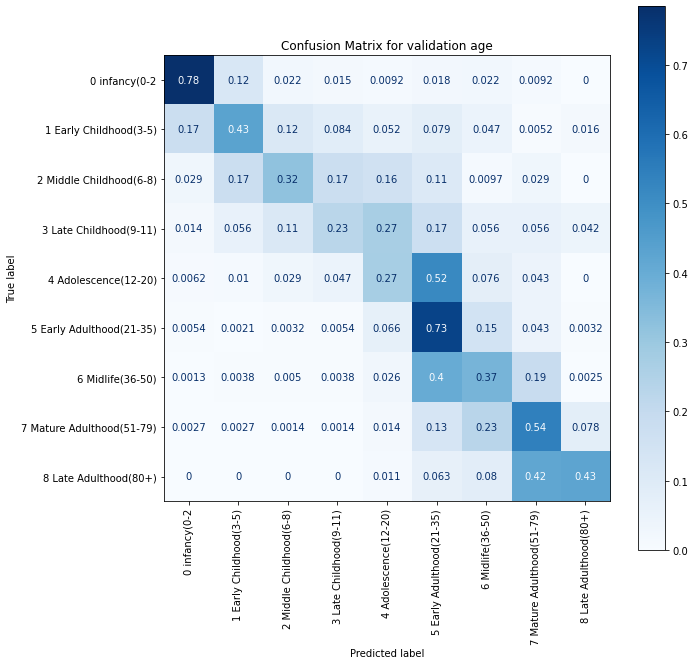

In [15]:
labels = ['0 infancy(0-2','1 Early Childhood(3-5)','2 Middle Childhood(6-8)','3 Late Childhood(9-11)','4 Adolescence(12-20)'
          ,'5 Early Adulthood(21-35)','6 Midlife(36-50)','7 Mature Adulthood(51-79)','8 Late Adulthood(80+)']
cm = confusion_matrix(np.argmax(ypredval,axis=1),y_val,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title('Confusion Matrix for validation age')
plt.xticks(rotation = 90)

plt.show()

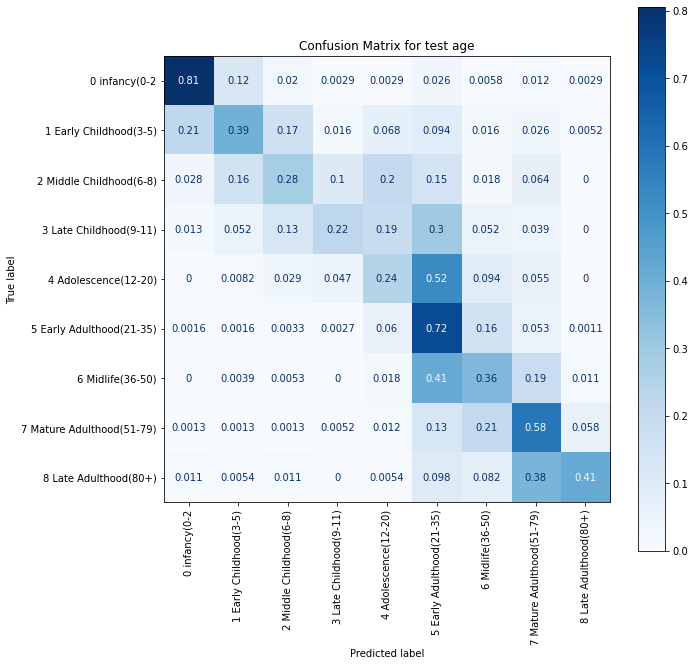

In [16]:
labels = ['0 infancy(0-2','1 Early Childhood(3-5)','2 Middle Childhood(6-8)','3 Late Childhood(9-11)','4 Adolescence(12-20)'
          ,'5 Early Adulthood(21-35)','6 Midlife(36-50)','7 Mature Adulthood(51-79)','8 Late Adulthood(80+)']
cm = confusion_matrix(np.argmax(ypredtest,axis=1),y_test,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title('Confusion Matrix for test age')
plt.xticks(rotation = 90)

plt.show()

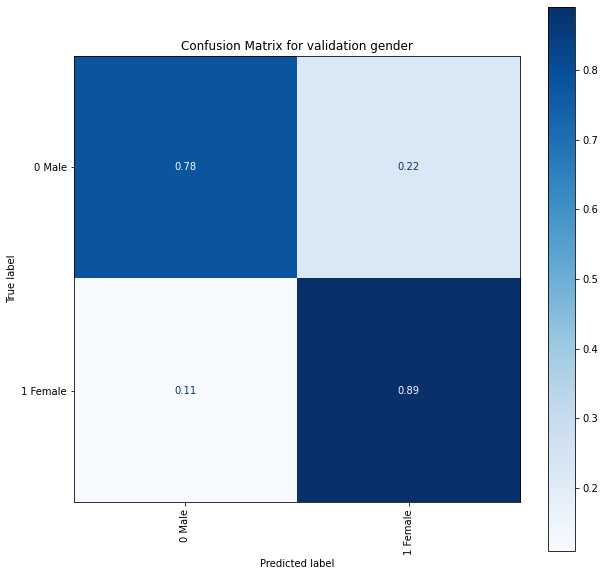

In [21]:
labels = ['0 Male','1 Female']
cm = confusion_matrix(y_val, np.argmax(ypredval,axis=1),normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title('Confusion Matrix for validation gender')
plt.xticks(rotation = 90)

plt.show()

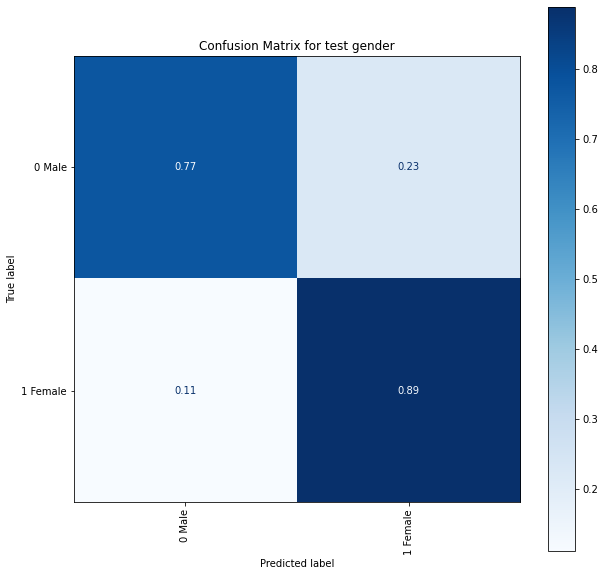

In [22]:
labels = ['0 Male','1 Female']
cm = confusion_matrix(y_test, np.argmax(ypredtest,axis=1),normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title('Confusion Matrix for test gender')
plt.xticks(rotation = 90)

plt.show()

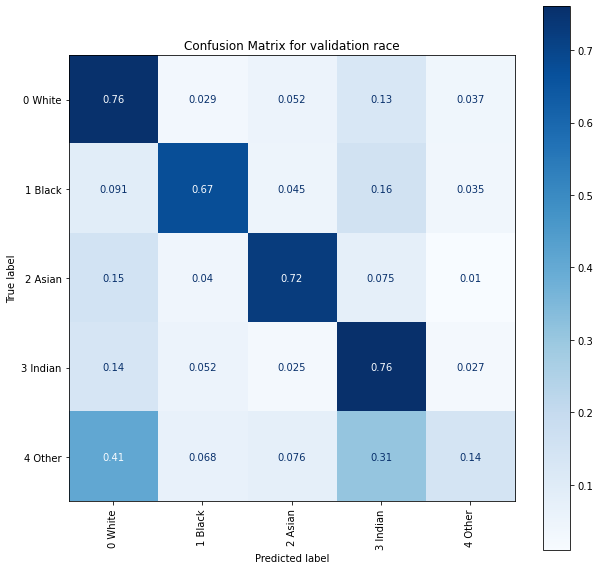

In [15]:
labels = ['0 White','1 Black','2 Asian','3 Indian','4 Other']
cm = confusion_matrix(y_val, np.argmax(ypredval,axis=1),normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title('Confusion Matrix for validation race')
plt.xticks(rotation = 90)

plt.show()

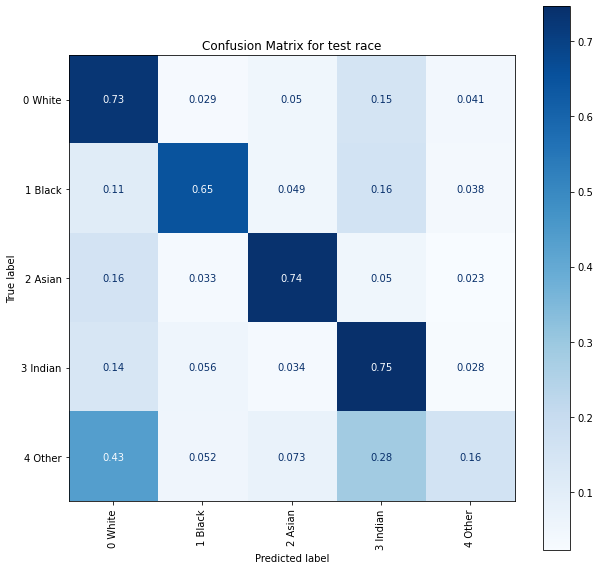

In [16]:
labels = ['0 White','1 Black','2 Asian','3 Indian','4 Other']
cm = confusion_matrix(y_test, np.argmax(ypredtest,axis=1),normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title('Confusion Matrix for test race')
plt.xticks(rotation = 90)

plt.show()

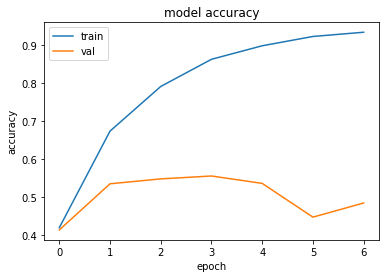

In [17]:
plt.plot(val_history.history['accuracy'])
plt.plot(val_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

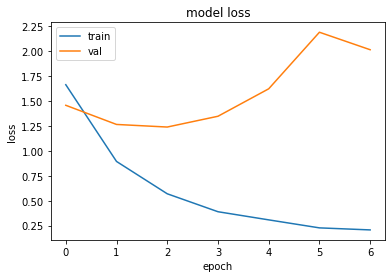

In [18]:
plt.plot(val_history.history['loss'])
plt.plot(val_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
ypredage = CNNmodel.predict(test_img_container)


149/149 [==============================] - 25s 168ms/step


In [20]:
a = y_test
b = np.zeros((a.size, a.max()+1))
b[np.arange(a.size),a] = 1
b

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(Nlabels):
    fpr[i], tpr[i], _ = roc_curve(b[:, i], ypredage[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(b.ravel(), ypredage.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

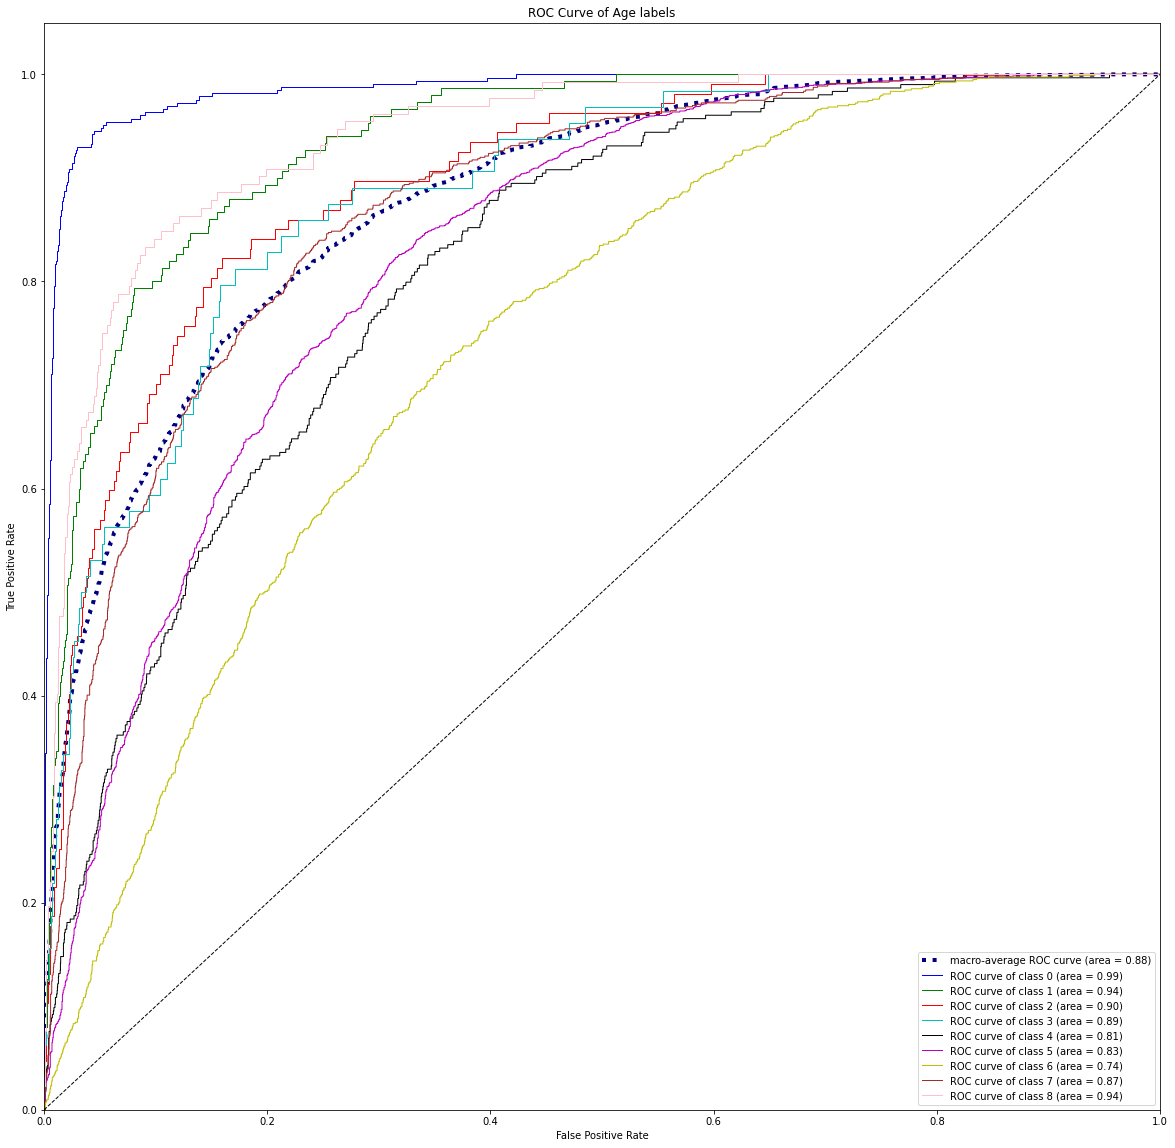

In [26]:

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(Nlabels)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(Nlabels):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= Nlabels

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(20,20))
lw = 1

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(['b','g','r','c','k','m','y','brown','pink'])
for i, color in zip(range(Nlabels), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve of Age labels")
plt.legend(loc="lower right")
plt.show()

In [10]:
model = tf.keras.models.load_model('CNNmodelgrey10000.h5')

In [27]:
CNNmodel.save('CNNmodelgreysobel10000dp04.h5')

In [53]:
def CNNmodeliteration(l1array,l2array,dropoutarray):
    for l1val in l1array:
        for l2val in l2array:
            for dropval in dropoutarray:
                l1reg = l1val
                l2reg = l2val
                dropoutn = dropval
                # Pick number of final nodes based on label picked
                Nlabels = -1
                if(Labeltype == 'age'):
                    Nlabels = 9
                if(Labeltype == 'gender'):
                    Nlabels = 2
                if(Labeltype == 'race'):
                    Nlabels = 5
                
                # Model creation
                CNNmodel = models.Sequential()
                CNNmodel.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train_expand[0].shape, kernel_regularizer = L1L2(l1=l1reg, l2=l2reg)))
                CNNmodel.add(Dropout(dropoutn))
                CNNmodel.add(layers.MaxPooling2D((2, 2)))
                CNNmodel.add(layers.Conv2D(32, (3, 3), activation='relu',kernel_regularizer = L1L2(l1=l1reg, l2=l2reg)))
                CNNmodel.add(Dropout(dropoutn))
                CNNmodel.add(layers.MaxPooling2D((2, 2)))
                CNNmodel.add(layers.MaxPooling2D((2, 2)))
                CNNmodel.add(layers.Conv2D(32, (3, 3), activation='relu',kernel_regularizer = L1L2(l1=l1reg, l2=l2reg)))
                CNNmodel.add(Dropout(dropoutn))
                CNNmodel.add(layers.Flatten())
                CNNmodel.add(layers.Dense(32, activation='relu'))
                CNNmodel.add(layers.Dense(1, activation='relu'))
                CNNmodel.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])
                #CNNmodel.add(layers.Dense(Nlabels, activation='softmax'))
                #CNNmodel.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])                
                # Validation training and testing
                val_history = CNNmodel.fit(train_img_container, dfbalancedsubset.loc[:,'label'], epochs=10, validation_data=(validation_img_container, y_val))
                # Get validation accuracy and confusion matrix
                val_accuracy = val_history.history['val_accuracy']
                ypred = CNNmodel.predict(X_val_expand)
                valconmatrix = confusion_matrix(np.argmax(ypred, axis=-1),y_val)
                print(val_accuracy)
                # Get test accuracy and confusion matrix
                ypred = CNNmodel.predict(test_img_container)
                testconmatrix = confusion_matrix(np.argmax(ypred, axis=-1),y_test)
                test_accuracy = accuracy_score(y_test, np.argmax(ypred, axis=-1))
                print(test_accuracy)
                print(l1reg)
                print(l2reg)
                print(dropoutn)
                l1history.append(l1reg)
                l2history.append(l2reg)
                dropouthistory.append(dropoutn)
                valhistory.append(val_accuracy)
                testhistory.append(test_accuracy)
                conhistory.append(testconmatrix)